<a href="https://colab.research.google.com/github/pulseq/MR-Physics-with-Pulseq/blob/main/tutorials/01_basic_sequences/notebooks/04_from_gre1d_to_fully_relaxed_gre2d.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# From 1D GRE to fully-relaxed 2D GRE sequence
Now, let's move from spectroscopy to imaging using 2D spatial encoding!:)   
**Exercise**
1. This is a simple 1D GRE sequence with readout in x direction. Could you add a gradient in y direction for **phase encoding**?
2. Do you know why there are artifacts in the reconstructed image? How can you suppress these artifacts? (Hint: try to change TR for **full relaxation**)
3. (optional) instead of increasing TR, you can also use **RF/gradient spoilers** to dephase residual magnetization. A "**gradient surgery**" can be used to even shorten TR. Uncomment the gradient spoiling part and get familiar with it. The concept of spoiling will be introduced in the topic: "Gradient echoes and steady state" later. The gradient surgery will also be used in later lectures, such as EPI and MRS.


In [ ]:
#@title 2D GRE in a  brain phantom - environment setup
#!pip show pypulseq || pip install pypulseq &> /dev/null
!pip install git+https://github.com/FrankZijlstra/pypulseq.git@bugfixes
!wget https://raw.githubusercontent.com/pulseq/MR-Physics-with-Pulseq/main/utils/utils.py &> /dev/null
import math
import warnings
import numpy as np
from matplotlib import pyplot as plt
import pypulseq as mr
# for simulation
!pip show MRzeroCore || pip install MRzeroCore
!wget https://github.com/MRsources/MRzero-Core/raw/main/documentation/playground_mr0/util.py &> /dev/null
!wget https://github.com/MRsources/MRzero-Core/raw/main/documentation/playground_mr0/numerical_brain_cropped.mat &> /dev/null
import utils # several helper functions for simulation and recon
import MRzeroCore as mr0

  Cloning https://github.com/FrankZijlstra/pypulseq.git (to revision bugfixes) to /tmp/pip-req-build-l_7x82b9
  Running command git clone --filter=blob:none --quiet https://github.com/FrankZijlstra/pypulseq.git /tmp/pip-req-build-l_7x82b9
  Running command git checkout -b bugfixes --track origin/bugfixes
  Switched to a new branch 'bugfixes'
  Branch 'bugfixes' set up to track remote branch 'bugfixes' from 'origin'.
  Resolved https://github.com/FrankZijlstra/pypulseq.git to commit a9d1e0329482378e2599d98e1ed4acf239eabbba
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 234.0/234.0 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.6/108.6 kB 11.7 MB/s eta 0:00:00
  Created wheel for pypulseq: filename=pypulseq-1.4.0-py3-none-any.whl size=269737 sha256=a19d4884c871c607560d944388c7c3878208660e28f0c9b36d53fa6f48e82d9c
  Stored in directory: /tmp/pip-ephem-wheel-cache-1j18vv7w/wheels/89/3e/7e/ce0c750c81d41d3838dcc1ce7c7c97a1d203

/usr/local/lib/python3.10/dist-packages/sigpy/config.py:15: UserWarning: Importing cupy failed. For more details, see the error stack below:

Failed to import CuPy.

If you installed CuPy via wheels (cupy-cudaXXX or cupy-rocm-X-X), make sure that the package matches with the version of CUDA or ROCm installed.

On Linux, you may need to set LD_LIBRARY_PATH environment variable depending on how you installed CUDA/ROCm.
On Windows, try setting CUDA_PATH environment variable.

Check the Installation Guide for details:
  https://docs.cupy.dev/en/latest/install.html

Original error:
  ImportError: libcuda.so.1: cannot open shared object file: No such file or directory

  warnings.warn(


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.1/349.1 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 16.5 MB/s eta 0:00:00


Timing check passed successfully


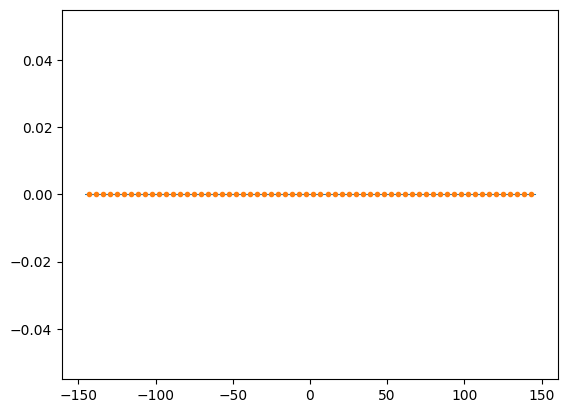

In [ ]:
#@title 2D GRE in a brain phantom - sequence
# %% DEFINE the sequence, FOV and resolution
fov=220e-3
Nread=64
Nphase=1#Nread
Nrep=1
TE=6e-3
TR=60e-3

experiment_id = 'gre2d'
# %% SETUP system
# choose the scanner limits
system = mr.Opts(
    max_grad=28, grad_unit='mT/m', max_slew=150, slew_unit='T/m/s',
    rf_ringdown_time=20e-6, rf_dead_time=100e-6,
    adc_dead_time=20e-6, grad_raster_time=10e-6)

seq=mr.Sequence(system)

# Define rf event
# hard pulse for excitation
rf_ex = mr.make_block_pulse(flip_angle=90*np.pi/180, duration=1e-3, phase_offset=0*np.pi/180, system=system)

# Define ADC event and gradients
adc = mr.make_adc(num_samples=Nread, duration=5.12e-3, phase_offset=0*np.pi/180, system=system)
deltak = 1/fov
# readout gradient
gx = mr.make_trapezoid(channel='x', flat_area=Nread*deltak, rise_time=adc.delay,flat_time=adc.dwell*adc.num_samples, system=system)
gxPre = mr.make_trapezoid(channel='x', area=-gx.area/2, duration=1e-3, system=system)

# Do a "gradient surgery" for spoiling.
# we cut the RO gradient into two parts for the optimal spoiler timing
#gx1, _ = mr.split_gradient_at(grad=gx, time_point=gx.rise_time+gx.flat_time)
# gradient spoiling
#gxSpoil = mr.make_extended_trapezoid_area(channel=gx.channel, grad_start=gx.amplitude, grad_end=0, area=2*Nread*deltak, system=system)[0]
#gxSpoil.delay = mr.calc_duration(gx1)
#gx_add = mr.add_gradients(grads=(gx1, gxSpoil),system=system)

# calculate timing
delayTE = np.ceil((TE-mr.calc_duration(gxPre) - rf_ex.shape_dur/2-rf_ex.ringdown_time-adc.delay-adc.dwell*adc.num_samples/2)/seq.grad_raster_time)*seq.grad_raster_time
delayTR = np.ceil((TR - mr.calc_duration(rf_ex) - delayTE - mr.calc_duration(gxPre) - mr.calc_duration(gx))/seq.grad_raster_time)*seq.grad_raster_time ;
assert(delayTE>=0)
assert(delayTR>=0)
# ======
# CONSTRUCT SEQUENCE
# ======

for i in range(0, Nphase):
  seq.add_block(rf_ex)
  seq.add_block(mr.make_delay(delayTE))
  #gyPre = mr.make_trapezoid(channel='y',area=(i-Nphase/2)*deltak, duration=mr.calc_duration(gxPre),system=system)
  #gyReph = mr.scale_grad(gyPre, -1)
  #gyReph.delay = mr.calc_duration(gx1) # for spoiling
  seq.add_block(gxPre)
  seq.add_block(gx, adc)
  #seq.add_block(gx_add, adc, gyReph) # for spoiling
  seq.add_block(mr.make_delay(delayTR))

(ok, error_report) = seq.check_timing()  # Check whether the timing of the sequence is correct
if ok:
    print("Timing check passed successfully")
else:
    print("Timing check failed. Error listing follows:")
    [print(e) for e in error_report]

# Plot k-space trajectory
k_traj_adc, k_traj, t_excitation, t_refocusing, t_adc = seq.calculate_kspace()

plt.figure()
plt.plot(k_traj[0],k_traj[1])
plt.plot(k_traj_adc[0],k_traj_adc[1],'.')

# Prepare the sequence output for the scanner
seq.set_definition('Name', 'gre2d')
seq.write('04_gre1d2gre2d.seq')

VoxelGridPhantom
size = tensor([0.2000, 0.2000, 0.0080])


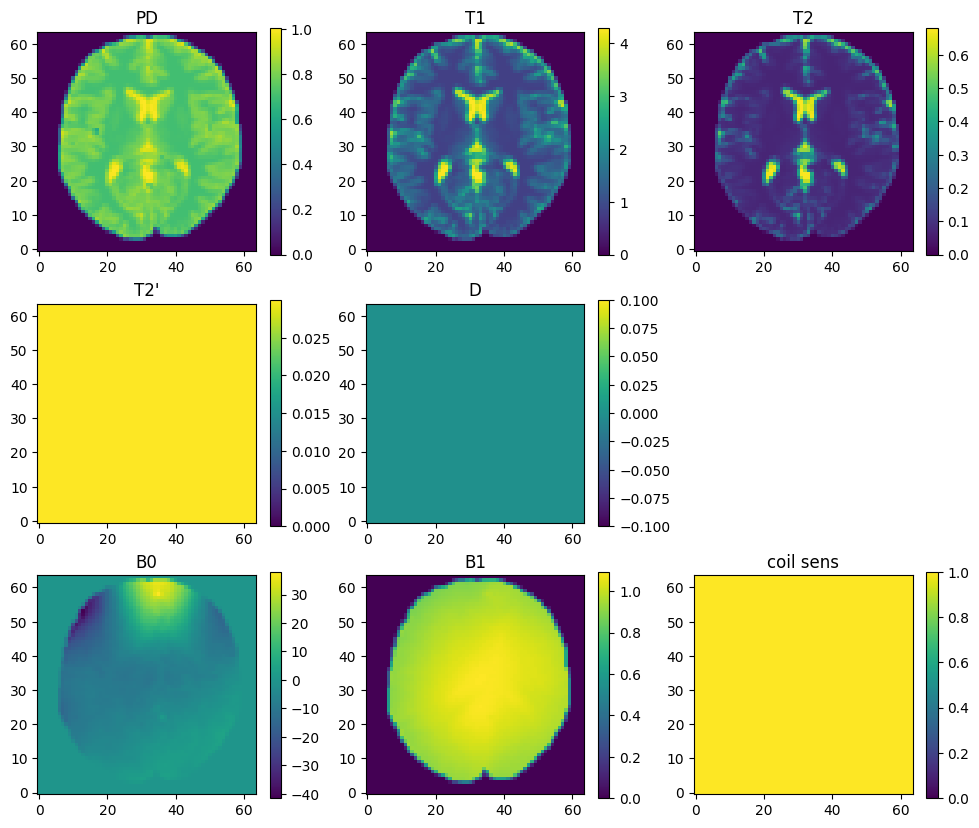

/usr/local/lib/python3.10/dist-packages/MRzeroCore/phantom/voxel_grid_phantom.py:146: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(shape, device=self.PD.device) / 2 / self.size,


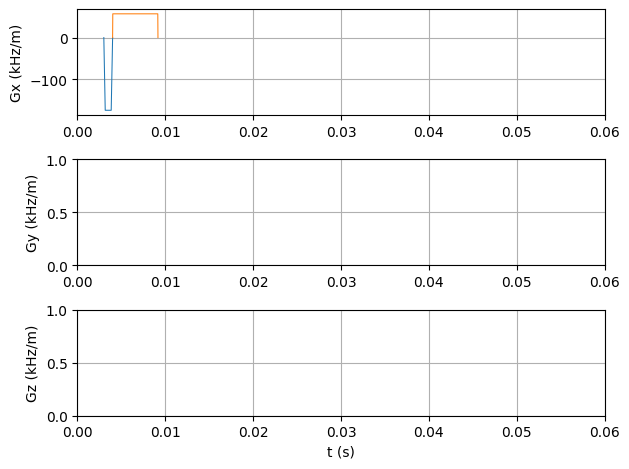

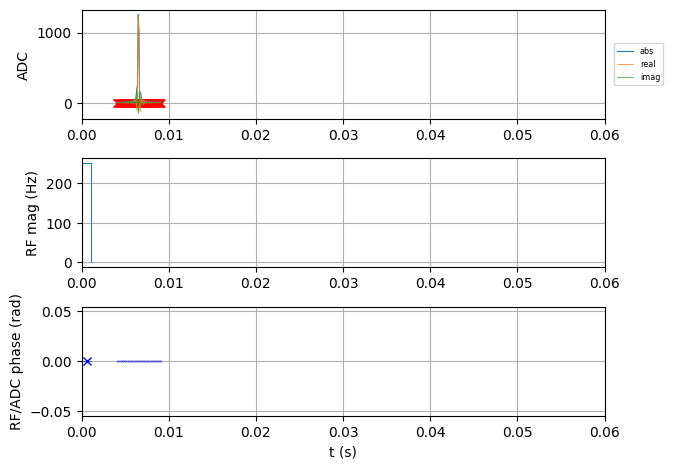

In [ ]:
#@title 2D GRE in a brain phantom - simulation
dB0 = 0
sz = [64, 64]
# %% S4: SETUP SPIN SYSTEM/object on which we can run the MR sequence external.seq from above
# (i) load a phantom object from file
obj_p = mr0.VoxelGridPhantom.load_mat('numerical_brain_cropped.mat')
obj_p = obj_p.interpolate(sz[0], sz[1], 1)
# Manipulate loaded data
obj_p.T2dash[:] = 30e-3
obj_p.D *= 0
obj_p.B0 *= 1    # alter the B0 inhomogeneity
# Store PD and B0 for comparison
PD = obj_p.PD
B0 = obj_p.B0
# Manipulate loaded data
obj_p.B0+=dB0
obj_p.D*=0
obj_p.plot()
# Convert Phantom into simulation data
obj_p=obj_p.build()

# %% SIMULATE  the external.seq file and add acquired signal to ADC plot
# Read in the sequence
seq0 = mr0.Sequence.import_file("04_gre1d2gre2d.seq")
#seq0.plot_kspace_trajectory()
# Simulate the sequence
graph=mr0.compute_graph(seq0, obj_p, 200, 1e-3)
signal=mr0.execute_graph(graph, seq0, obj_p, print_progress=False)
# PLOT sequence with signal in the ADC subplot
seq.plot(plot_now=False)
mr0.util.insert_signal_plot(seq=seq, signal =signal.numpy())
plt.show()


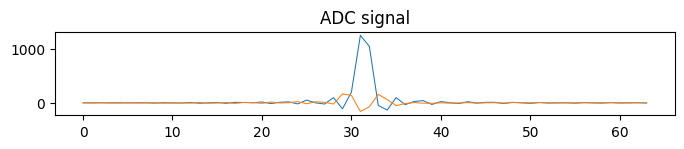

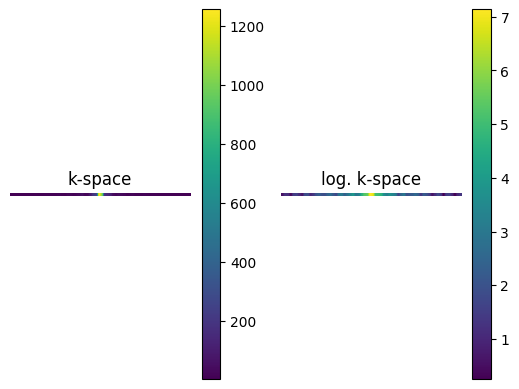

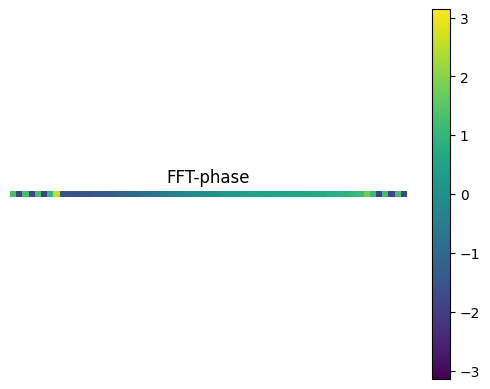

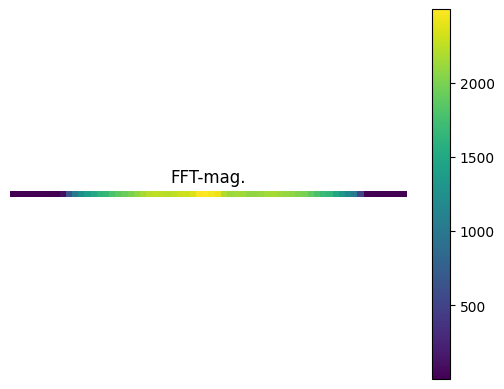

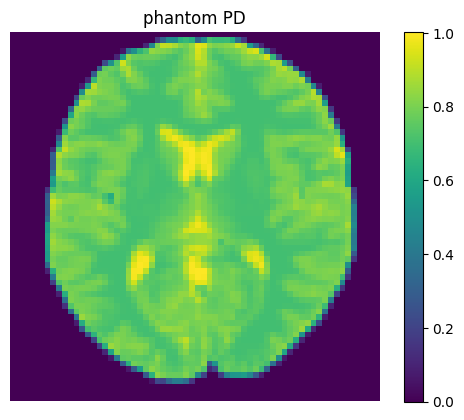

In [ ]:
#@title 2D GRE in a brain phantom - reconstruction
# 2D FFT
def fft_2d(x):
    return np.fft.fftshift(np.fft.fftn(np.fft.ifftshift(x)))

kspace = np.reshape(signal, (Nphase, Nread))
im = fft_2d(kspace)

fig = plt.figure(figsize=(8, 5))  # fig.clf()
plt.subplot(411)
plt.title('ADC signal')
plt.plot(np.real(signal), label='real')
plt.plot(np.imag(signal), label='imag')

plt.figure()
plt.subplot(121)
plt.title('k-space')
plt.imshow(np.abs(kspace)); plt.axis('off');plt.colorbar()
plt.subplot(122)
plt.title('log. k-space')
plt.imshow(np.log(np.abs(kspace))); plt.axis('off');plt.colorbar()
plt.figure()
plt.title('FFT-phase')
plt.imshow(np.angle(im), vmin=-np.pi, vmax=np.pi, origin="lower"); plt.axis('off')
plt.colorbar()
plt.figure()
plt.title('FFT-mag.')
plt.imshow(np.abs(im), origin="lower"); plt.axis('off');plt.colorbar()
plt.figure()
plt.title('phantom PD')
plt.imshow(PD.squeeze().T, origin="lower"); plt.axis('off');plt.colorbar()